In [1]:
# Cài đặt thư viện cần thiết
!pip install autocorrect

# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Đã cài đặt thư viện và kết nối Google Drive.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=23c4bd706ebba17975800085ff53362ceba66181e3f2316b589d86a84db2e8e6
  Stored in directory: /root/.cache/pip/wheels/5e/90/99/807a5ad861ce5d22c3c299a11df8cba9f31524f23ae6e645cb
Successfully built autocorrect


ValueError: mount failed

In [1]:
# Nhập các thư viện cần thiết
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Đọc dữ liệu
data_path = '/content/drive/MyDrive/AI_Human.csv'
df = pd.read_csv(data_path)
print("Dữ liệu đầu vào:")
print(df.head())
print("\nPhân bố nhãn:")
print(df['generated'].value_counts())

# Chuyển nhãn thành số nguyên
df['label'] = df['generated'].astype(int)

# Xóa dòng có giá trị thiếu
df = df.dropna()
print(f"\nSố dòng sau khi xóa giá trị thiếu: {len(df)}")

# Làm sạch văn bản
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['text'] = df['text'].apply(clean_text)
print("Ví dụ văn bản sau khi làm sạch:")
print(df['text'].iloc[0][:200])

# Lưu dữ liệu đã xử lý
output_path = '/content/drive/MyDrive/processed_data.csv'
df.to_csv(output_path, index=False)
print(f"Đã lưu dữ liệu đã xử lý vào: {output_path}")

# Tokenization và padding
maxlen = 512
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
vocab_size = len(tokenizer.word_index) + 1
print(f"\nKích thước từ vựng: {vocab_size}")
print(f"Hình dạng của padded_sequences: {padded_sequences.shape}")

# Lưu padded sequences, nhãn và tokenizer
np.save('/content/drive/MyDrive/padded_sequences.npy', padded_sequences)
np.save('/content/drive/MyDrive/labels.npy', df['label'].values)
with open('/content/drive/MyDrive/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Đã lưu padded sequences, nhãn và tokenizer.")

Dữ liệu đầu vào:
                                                text  generated
0  Cars. Cars have been around since they became ...        0.0
1  Transportation is a large necessity in most co...        0.0
2  "America's love affair with it's vehicles seem...        0.0
3  How often do you ride in a car? Do you drive a...        0.0
4  Cars are a wonderful thing. They are perhaps o...        0.0

Phân bố nhãn:
generated
0.0    305797
1.0    181438
Name: count, dtype: int64

Số dòng sau khi xóa giá trị thiếu: 487235
Ví dụ văn bản sau khi làm sạch:
cars. cars have been around since they became famous in the 1900s, when henry ford created and built the first modelt. cars have played a major role in our every day lives since then. but now, people 
Đã lưu dữ liệu đã xử lý vào: /content/drive/MyDrive/processed_data.csv

Kích thước từ vựng: 282665
Hình dạng của padded_sequences: (487235, 512)
Đã lưu padded sequences, nhãn và tokenizer.


In [2]:
from sklearn.model_selection import train_test_split

# Đọc padded sequences và nhãn
X = np.load('/content/drive/MyDrive/padded_sequences.npy')
y = np.load('/content/drive/MyDrive/labels.npy')

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Hình dạng X_train:", X_train.shape)
print("Hình dạng X_test:", X_test.shape)
print("Hình dạng y_train:", y_train.shape)
print("Hình dạng y_test:", y_test.shape)

# Lưu dữ liệu đã chia
np.save('/content/drive/MyDrive/X_train.npy', X_train)
np.save('/content/drive/MyDrive/X_test.npy', X_test)
np.save('/content/drive/MyDrive/y_train.npy', y_train)
np.save('/content/drive/MyDrive/y_test.npy', y_test)
print("Đã lưu dữ liệu huấn luyện và kiểm tra.")

Hình dạng X_train: (389788, 512)
Hình dạng X_test: (97447, 512)
Hình dạng y_train: (389788,)
Hình dạng y_test: (97447,)
Đã lưu dữ liệu huấn luyện và kiểm tra.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Các hàm định nghĩa mô hình (giữ nguyên)
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.5):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, kernel_regularizer=regularizers.l2(1e-2))(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn = Dense(ff_dim, kernel_regularizer=regularizers.l2(1e-2))(out1)
    ffn = tf.keras.layers.ReLU()(ffn)
    ffn = Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-2))(ffn)
    ffn = Dropout(rate)(ffn)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn)

def build_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_blocks=2, dropout_rate=0.3):
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    pos_encoding = positional_encoding(maxlen, embed_dim)
    x += pos_encoding[:, :maxlen, :]
    for _ in range(num_blocks):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, rate=dropout_rate)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=[Precision(name='precision'), Recall(name='recall')])
    return model

print("Đã định nghĩa các hàm mô hình.")

Đã định nghĩa các hàm mô hình.


Đã đọc dữ liệu huấn luyện và kiểm tra thành công.
Đã đọc tokenizer thành công.
Đã xây dựng mô hình thành công.
Epoch 1/10
6091/6091 ━━━━━━━━━━━━━━━━━━━━ 610s 97ms/step - loss: 1.5995 - precision: 0.9551 - recall: 0.9011 - val_loss: 0.0287 - val_precision: 0.9993 - val_recall: 0.9942
Epoch 2/10
6091/6091 ━━━━━━━━━━━━━━━━━━━━ 607s 96ms/step - loss: 0.0234 - precision: 0.9984 - recall: 0.9967 - val_loss: 0.0169 - val_precision: 0.9996 - val_recall: 0.9951
Epoch 3/10
6091/6091 ━━━━━━━━━━━━━━━━━━━━ 623s 96ms/step - loss: 0.0134 - precision: 0.9992 - recall: 0.9984 - val_loss: 0.0112 - val_precision: 0.9984 - val_recall: 0.9988
Epoch 4/10
6091/6091 ━━━━━━━━━━━━━━━━━━━━ 620s 96ms/step - loss: 0.0096 - precision: 0.9993 - recall: 0.9989 - val_loss: 0.0093 - val_precision: 0.9980 - val_recall: 0.9991
Epoch 5/10
6091/6091 ━━━━━━━━━━━━━━━━━━━━ 544s 89ms/step - loss: 0.0073 - precision: 0.9995 - recall: 0.9993 - val_loss: 0.0086 - val_precision: 0.9995 - val_recall: 0.9974
Epoch 6/10
6091/6091 ━━━

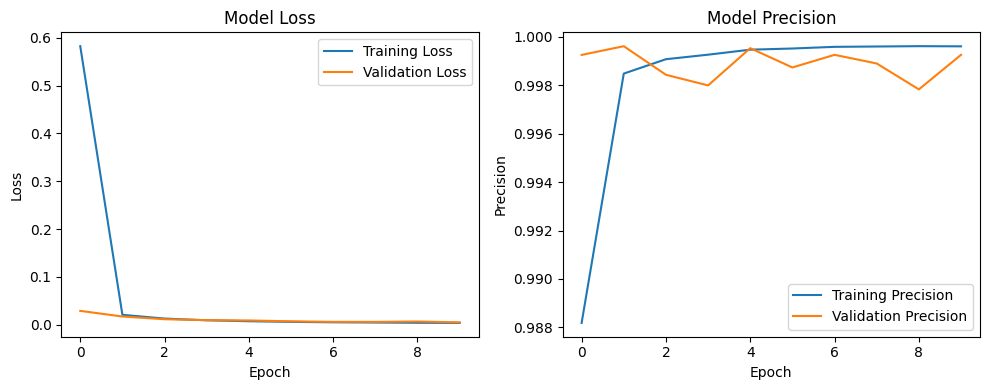

Đã lưu biểu đồ lịch sử huấn luyện vào: /content/drive/MyDrive/training_history_plot.png


In [4]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import os

# Đọc dữ liệu huấn luyện và kiểm tra
try:
    X_train = np.load('/content/drive/MyDrive/X_train.npy')
    y_train = np.load('/content/drive/MyDrive/y_train.npy')
    X_test = np.load('/content/drive/MyDrive/X_test.npy')
    y_test = np.load('/content/drive/MyDrive/y_test.npy')
    print("Đã đọc dữ liệu huấn luyện và kiểm tra thành công.")
except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file dữ liệu - {e}")
    raise

# Đọc tokenizer
try:
    with open('/content/drive/MyDrive/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    print("Đã đọc tokenizer thành công.")
except FileNotFoundError as e:
    print(f"Lỗi: Không tìm thấy file tokenizer - {e}")
    raise

# Tham số
maxlen = 512
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 64
num_heads = 4
ff_dim = 128
batch_size = 64
epochs = 10

# Xây dựng mô hình (giả định build_model đã được định nghĩa)
try:
    model = build_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
    print("Đã xây dựng mô hình thành công.")
except NameError as e:
    print(f"Lỗi: Hàm build_model chưa được định nghĩa - {e}")
    raise

# Huấn luyện mô hình
try:
    history = model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(X_test, y_test),
                       verbose=1)
    print("Đã hoàn thành huấn luyện mô hình.")
except Exception as e:
    print(f"Lỗi khi huấn luyện mô hình: {e}")
    raise

# Lưu mô hình ở định dạng .keras
model_path = '/content/drive/MyDrive/transformer_model.keras'
try:
    model.save(model_path)
    print(f"Đã lưu mô hình vào: {model_path}")
except Exception as e:
    print(f"Lỗi khi lưu mô hình: {e}")
    raise

# Vẽ lịch sử huấn luyện
try:
    plt.figure(figsize=(10, 4))

    # Biểu đồ Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Biểu đồ Precision
    plt.subplot(1, 2, 2)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Model Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plot_path = '/content/drive/MyDrive/training_history_plot.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Đã lưu biểu đồ lịch sử huấn luyện vào: {plot_path}")
except Exception as e:
    print(f"Lỗi khi vẽ biểu đồ: {e}")
    raise

Đã tải và biên dịch lại mô hình
3046/3046 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step
Độ chính xác: 0.9992
Độ chính xác (Precision): 0.9993
Độ bao phủ (Recall): 0.9987
F1-Score: 0.9990


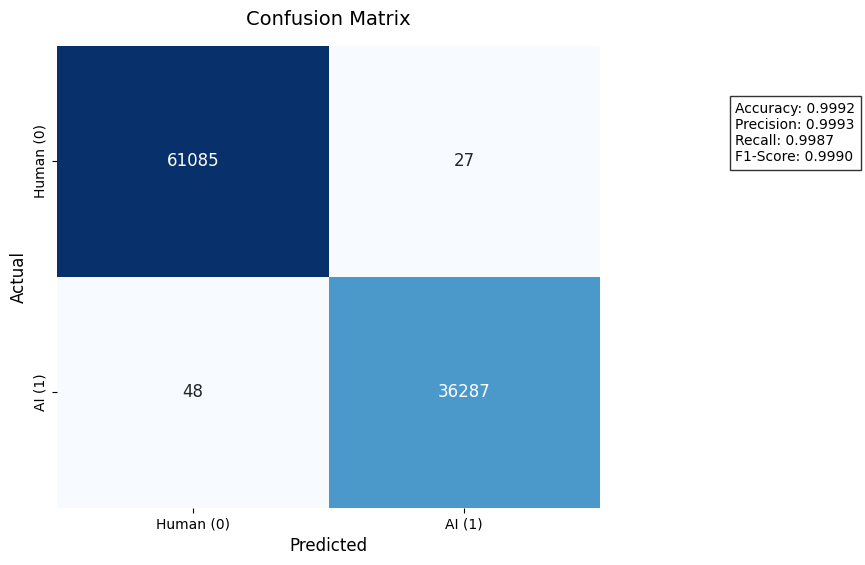

Đã lưu ma trận nhầm lẫn vào: /content/drive/MyDrive/confusion_matrix.png


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Đọc dữ liệu kiểm tra
X_test = np.load('/content/drive/MyDrive/X_test.npy')
y_test = np.load('/content/drive/MyDrive/y_test.npy')

# Định nghĩa hàm mã hóa vị trí
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Định nghĩa khối transformer
def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.5):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, kernel_regularizer=regularizers.l2(1e-2))(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn = Dense(ff_dim, kernel_regularizer=regularizers.l2(1e-2))(out1)
    ffn = tf.keras.layers.ReLU()(ffn)
    ffn = Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-2))(ffn)
    ffn = Dropout(rate)(ffn)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn)

# Định nghĩa hàm xây dựng mô hình
def build_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_blocks=2, dropout_rate=0.3):
    inputs = Input(shape=(maxlen,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    pos_encoding = positional_encoding(maxlen, embed_dim)
    x += pos_encoding[:, :maxlen, :]
    for _ in range(num_blocks):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, rate=dropout_rate)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=[Precision(name='precision'), Recall(name='recall')])
    return model

# Định nghĩa custom objects
custom_objects = {
    'MultiHeadAttention': MultiHeadAttention,
    'LayerNormalization': LayerNormalization
}

# Thử tải mô hình
try:
    model = tf.keras.models.load_model('/content/drive/MyDrive/transformer_model.keras',
                                      custom_objects=custom_objects, compile=False)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=[Precision(name='precision'), Recall(name='recall')])
    print("Đã tải và biên dịch lại mô hình")
except Exception as e:
    print(f"Không thể tải mô hình: {e}")
    print("Tái tạo mô hình mới...")
    with open('/content/drive/MyDrive/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    vocab_size = len(tokenizer.word_index) + 1
    maxlen = 512
    embed_dim = 64
    num_heads = 4
    ff_dim = 128
    model = build_model(maxlen, vocab_size, embed_dim, num_heads, ff_dim)
    print("Đã xây dựng lại mô hình")

# Dự đoán trên tập kiểm tra
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Tính các chỉ số hiệu suất
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# In các chỉ số
print(f"Độ chính xác: {accuracy:.4f}")
print(f"Độ chính xác (Precision): {precision:.4f}")
print(f"Độ bao phủ (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Human (0)', 'AI (1)'], yticklabels=['Human (0)', 'AI (1)'],
            annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14, pad=15)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)

# Thêm văn bản hiển thị các chỉ số
metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}"
plt.text(2.5, 0.5, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Lưu biểu đồ
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu ma trận nhầm lẫn vào: /content/drive/MyDrive/confusion_matrix.png")